In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from imblearn import over_sampling

from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel('../input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx', sheet_name=1)
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
df_dict = pd.read_excel('../input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx', sheet_name=0)
df_dict.columns = df_dict.iloc[0]
df_dict = df_dict[1:].reset_index()
df_dict[['Variable','Discerption']]

,Variable,Discerption
0,CustomerID,Unique customer ID
1,Churn,Churn Flag
2,Tenure,Tenure of customer in organization
3,PreferredLoginDevice,Preferred login device of customer
4,CityTier,City tier
5,WarehouseToHome,Distance in between warehouse to home of customer
6,PreferredPaymentMode,Preferred payment method of customer
7,Gender,Gender of customer
8,HourSpendOnApp,Number of hours spend on mobile application or...
9,NumberOfDeviceRegistered,Total number of deceives is registered on part...


# 1. EDA

In [4]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [5]:
summary('data',df)

data shape: (5630, 20)


,dtypes,null,unique,min,median,max,mean,std
CustomerID,int64,0,5630,50001,52815.50,55630,52815.500000,1625.385339
Churn,int64,0,2,0,0.00,1,0.168384,0.374240
Tenure,float64,264,36,0.0,9.00,61.0,10.189899,8.557241
PreferredLoginDevice,object,0,3,Computer,NaN,Phone,NaN,NaN
CityTier,int64,0,3,1,1.00,3,1.654707,0.915389
WarehouseToHome,float64,251,34,5.0,14.00,127.0,15.639896,8.531475
PreferredPaymentMode,object,0,7,CC,NaN,UPI,NaN,NaN
Gender,object,0,2,Female,NaN,Male,NaN,NaN
HourSpendOnApp,float64,255,6,0.0,3.00,5.0,2.931535,0.721926
NumberOfDeviceRegistered,int64,0,6,1,4.00,6,3.688988,1.023999


In [6]:
cats= ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
ordinal = ['CityTier', 'SatisfactionScore']
binary = ['Churn', 'Complain']
nums = df.loc[:, ~df.columns.isin(cats + binary + ordinal)].columns[1:]

In [7]:
df[cats].describe().T

,count,unique,top,freq
PreferredLoginDevice,5630,3,Mobile Phone,2765
PreferredPaymentMode,5630,7,Debit Card,2314
Gender,5630,2,Male,3384
PreferedOrderCat,5630,6,Laptop & Accessory,2050
MaritalStatus,5630,3,Married,2986


In [8]:
for col in cats:
    vc = df[col].value_counts().rename_axis(col).reset_index(name='Counts')
    display(vc)

,PreferredLoginDevice,Counts
0,Mobile Phone,2765
1,Computer,1634
2,Phone,1231


,PreferredPaymentMode,Counts
0,Debit Card,2314
1,Credit Card,1501
2,E wallet,614
3,UPI,414
4,COD,365
5,CC,273
6,Cash on Delivery,149


,Gender,Counts
0,Male,3384
1,Female,2246


,PreferedOrderCat,Counts
0,Laptop & Accessory,2050
1,Mobile Phone,1271
2,Fashion,826
3,Mobile,809
4,Grocery,410
5,Others,264


,MaritalStatus,Counts
0,Married,2986
1,Single,1796
2,Divorced,848


## Univariate Analysis

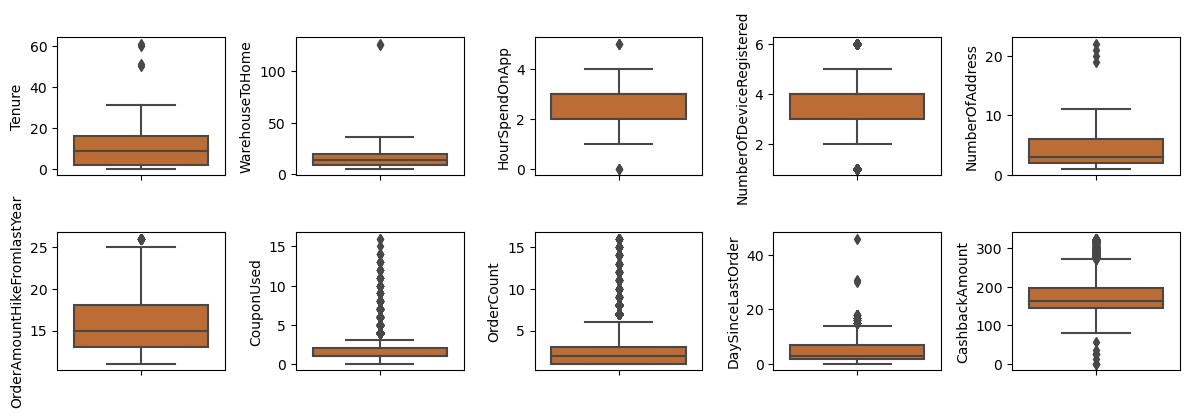

In [9]:
plt.figure(figsize=(12,4))
for i in range(0, len(nums)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[nums[i]], color='chocolate')
    plt.tight_layout()

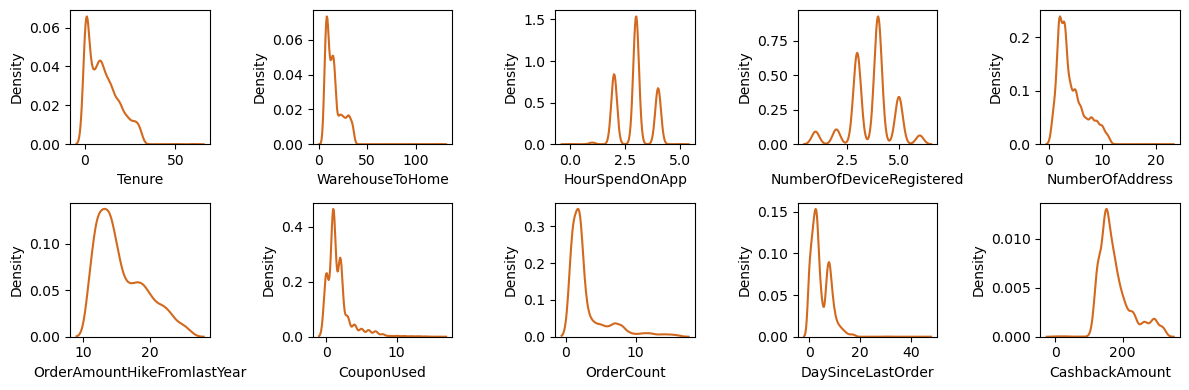

In [10]:
plt.figure(figsize=(12,4))
for i in range(0, len(nums)):
    plt.subplot(2,5,i+1)
    sns.kdeplot(x=df[nums[i]], color='chocolate')
    plt.tight_layout()

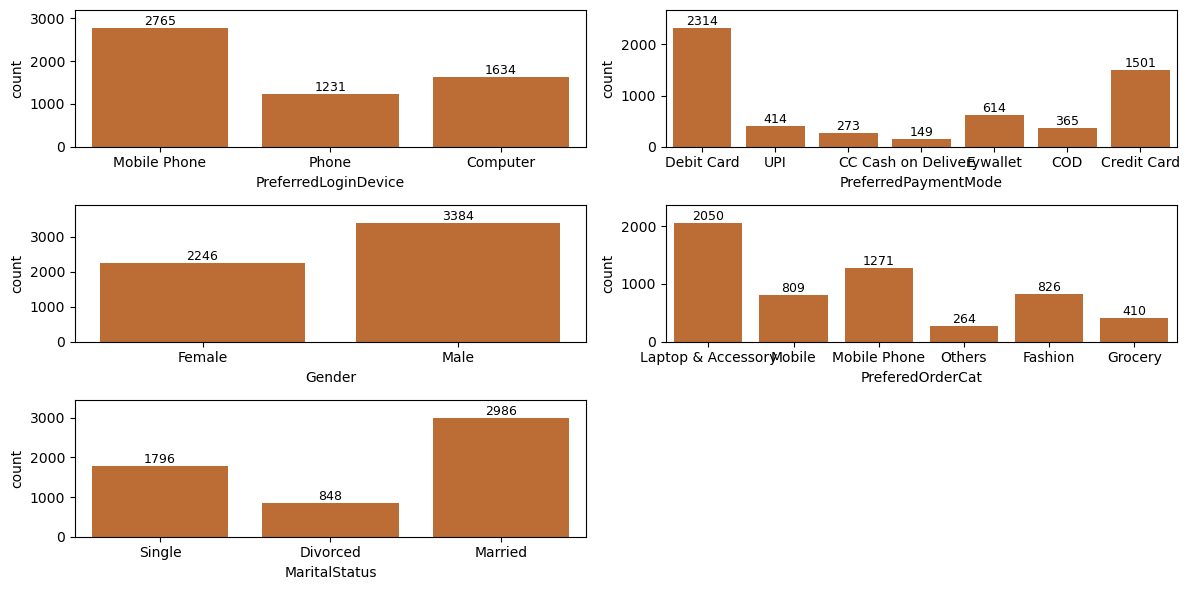

In [11]:
plt.figure(figsize=(12,6))
for i in range(0, len(cats)):
    plt.subplot(3, 2, i+1)
    ax = sns.countplot(x=df[cats[i]], color='chocolate')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)

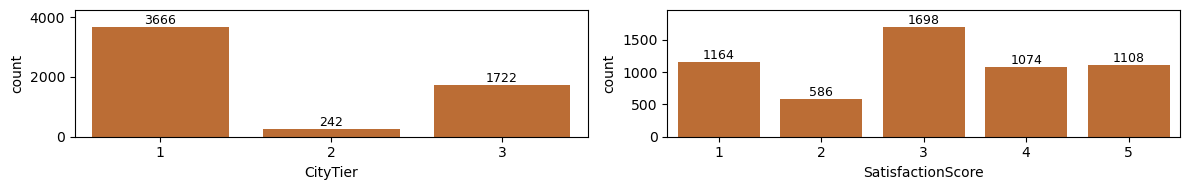

In [12]:
plt.figure(figsize=(12,2))
for i in range(0, len(ordinal)):
    plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=df[ordinal[i]], color='chocolate')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)

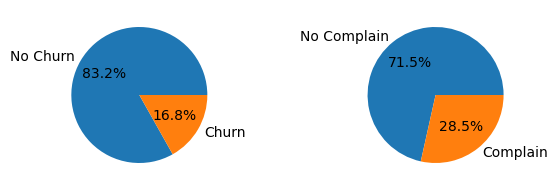

In [13]:
plt.figure(figsize=(12,2))
cats_bin = cats[4:]
for i in range(0, len(binary)):
    plt.subplot(1,4,i+1)
    data=df[binary[i]].value_counts()
    labels = [f'No {binary[i]}', f'{binary[i]}']
    plt.pie(data,labels=labels,autopct='%.1f%%')
    plt.tight_layout()

## Multivariate Analysis

<AxesSubplot:>

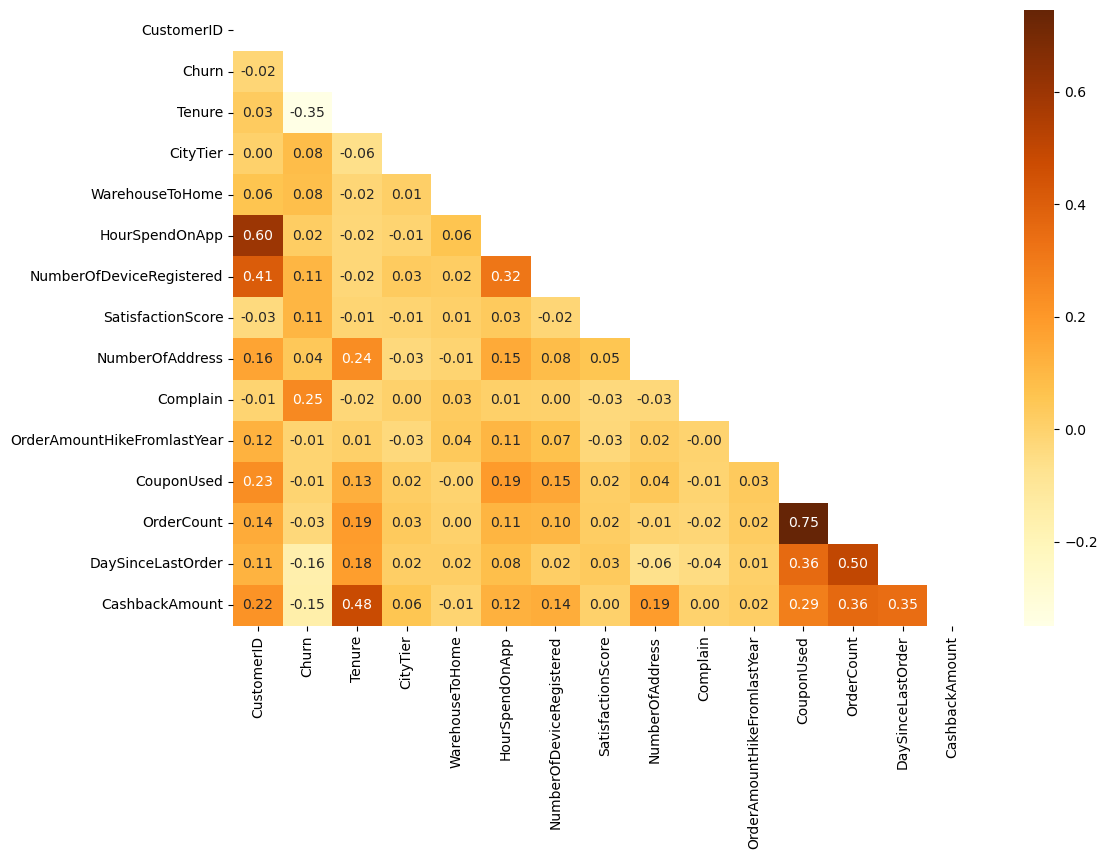

In [14]:
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlOrBr')

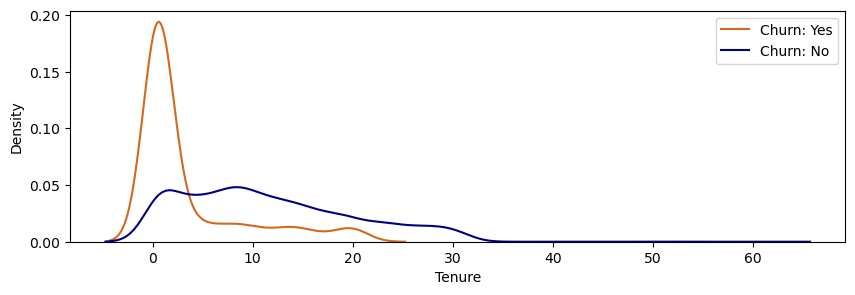

In [15]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.kdeplot(df[df['Churn'] == 1]['Tenure'].dropna(), color= 'chocolate', label= 'Churn: Yes', ax=ax)
sns.kdeplot(df[df['Churn'] == 0]['Tenure'].dropna(), color= 'navy', label= 'Churn: No', ax=ax)
plt.legend(loc = 1)

In [16]:
def churn_plot(x):
    df_cats = df.copy()
    df_city = df_cats.groupby(x)['CustomerID'].nunique().reset_index(name='Total')
    df_churn =  df_cats.groupby([x, 'Churn'])['CustomerID'].nunique().reset_index(name='TotalCustomer')
    df_merge = df_churn.merge(df_city, on=x)
    df_merge['Percentage'] = round(df_merge['TotalCustomer']/df_merge['Total']*100,2)
    
    return df_merge

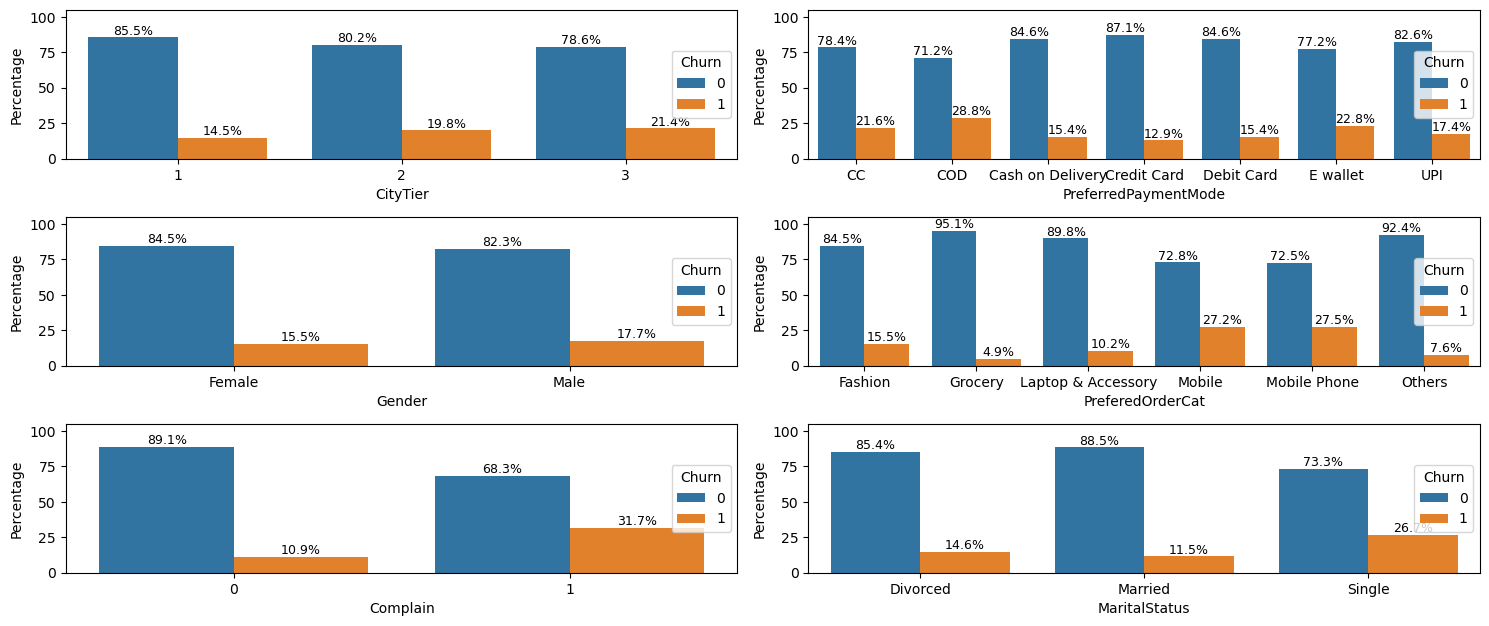

In [17]:
kolom = ['CityTier',  'PreferredPaymentMode', 'Gender', 'PreferedOrderCat','Complain',  'MaritalStatus']
plt.figure(figsize=(15,8))
for i in range(0, len(kolom)):
    plt.subplot(4, 2, i+1)
    data = churn_plot(kolom[i])
    ax = sns.barplot(x=kolom[i], y='Percentage', data=data, hue = 'Churn')

    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.1f%%')
        ax.set_ylim(top=105)
        ax.legend(loc='center right', title='Churn')
    plt.tight_layout()

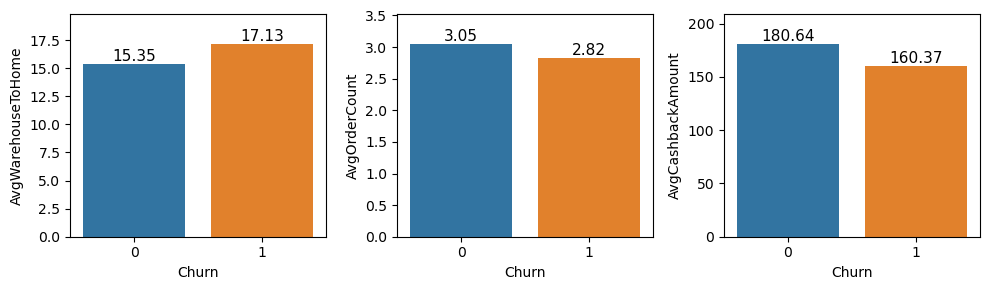

In [18]:
kolom = ['WarehouseToHome', 'OrderCount', 'CashbackAmount']
plt.figure(figsize=(10,3))
for i in range(0, len(kolom)):
    plt.subplot(1, 3, i+1)
    data = df.copy()
    data = data.groupby('Churn')[kolom[i]].mean().reset_index(name='Avg'+ kolom[i])
    ax = sns.barplot(x='Churn', y='Avg'+kolom[i], data=data)

    for container in ax.containers:
        ax.bar_label(container, fontsize=11, fmt='%.2f')
        ax.set_ylim(top=ax.get_ylim()[1]*1.1)
    plt.tight_layout()

# 2. Preprocessing

## Missing Values

In [19]:
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace=True)
df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median(), inplace=True)
df['CouponUsed'].fillna(df['CouponUsed'].median(), inplace=True)
df['OrderCount'].fillna(df['OrderCount'].median(), inplace=True)
df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median(), inplace=True)
df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median(), inplace=True)

## Outliers

In [20]:
print(f'before: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in nums:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df = df[filtered_entries]

print(f'after: {len(df)}')

before: 5630
after: 5350


## Duplicated Data

In [21]:
df.duplicated(subset=['CustomerID']).sum()

0

## Feature Encoding

### Label Encoding

In [22]:
df['Gender'] = df['Gender'].replace(['Female','Male'], [0, 1])
df['MaritalStatus'] = df['MaritalStatus'].replace(['Divorced'], ['Single'])
df['MaritalStatus'] = df['MaritalStatus'].replace(['Single','Married'], [0, 1])

### One Hot Encoding

In [23]:
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace(['Phone','Mobile Phone'], ['Handphone', 'Handphone'])
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace(['CC','COD'], ['Credit Card','Cash on Delivery'])
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace(['Mobile','Mobile Phone', 'Laptop & Accessory'], ['Handphone', 'Handphone', 'Laptop'])

In [24]:
df = pd.get_dummies(df)
df.head()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Handphone,PreferedOrderCat_Laptop,PreferedOrderCat_Others
0,50001,1,4.0,3,6.0,0,3.0,3,2,0,9,1,11.0,1.0,1.0,5.0,159.93,0,1,0,0,1,0,0,0,0,0,1,0
1,50002,1,9.0,1,8.0,1,3.0,4,3,0,7,1,15.0,0.0,1.0,0.0,120.90,0,1,0,0,0,0,1,0,0,1,0,0
2,50003,1,9.0,1,30.0,1,2.0,4,3,0,6,1,14.0,0.0,1.0,3.0,120.28,0,1,0,0,1,0,0,0,0,1,0,0
3,50004,1,0.0,3,15.0,1,2.0,4,5,0,8,0,23.0,0.0,1.0,3.0,134.07,0,1,0,0,1,0,0,0,0,0,1,0
4,50005,1,0.0,1,12.0,1,3.0,3,5,0,3,0,11.0,1.0,1.0,3.0,129.60,0,1,0,1,0,0,0,0,0,1,0,0


## Feature Transformation

In [25]:
df['AvgCashback'] = df['CashbackAmount'] / df['OrderCount']

In [26]:
column = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 
          'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 
          'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'AvgCashback']
for col in column:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(len(df),1))

In [27]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Handphone,PreferedOrderCat_Laptop,PreferedOrderCat_Others,AvgCashback
count,5350.000000,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5.350000e+03
mean,52802.826168,0.170467,7.171833e-17,-2.473618e-17,7.437457e-17,0.600748,-8.499950e-17,-8.499950e-17,1.726552e-16,0.528037,2.124988e-17,0.286355,9.562444e-17,-8.499950e-17,1.062494e-16,4.249975e-17,5.099970e-16,0.289159,0.710841,0.091402,0.315140,0.410280,0.108224,0.074953,0.140561,0.062056,0.383738,0.373832,0.039813,1.699990e-16
std,1627.280475,0.376078,1.000093e+00,1.000093e+00,1.000093e+00,0.489791,1.000093e+00,1.000093e+00,1.000093e+00,0.499260,1.000093e+00,0.452100,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,0.453414,0.453414,0.288207,0.464615,0.491931,0.310693,0.263341,0.347600,0.241280,0.486341,0.483865,0.195538,1.000093e+00
min,50001.000000,0.000000,-1.198863e+00,-7.143355e-01,-1.307003e+00,0.000000,-2.749372e+00,-2.607447e+00,-1.491615e+00,0.000000,-1.256326e+00,0.000000,-1.304506e+00,-1.078464e+00,-7.477119e-01,-1.294154e+00,-2.957067e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.821970e+00
25%,51394.250000,0.000000,-9.542994e-01,-7.143355e-01,-8.110482e-01,0.000000,-1.324620e+00,-6.580561e-01,-7.662794e-01,0.000000,-8.632882e-01,0.000000,-7.448567e-01,-3.699937e-01,-7.477119e-01,-6.825447e-01,-6.284652e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.757828e-01
50%,52784.500000,0.000000,-9.832813e-02,-7.143355e-01,-1.911048e-01,1.000000,1.001321e-01,3.166394e-01,-4.094416e-02,1.000000,-4.702500e-01,0.000000,-1.852073e-01,-3.699937e-01,-2.680071e-01,-3.767400e-01,-2.828504e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.799765e-01
75%,54208.750000,0.000000,6.353615e-01,1.474493e+00,5.528273e-01,1.000000,1.001321e-01,3.166394e-01,6.843911e-01,1.000000,7.088646e-01,1.000000,6.542668e-01,3.384767e-01,2.116978e-01,8.464789e-01,3.641027e-01,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.055236e-01
max,55630.000000,1.000000,2.591867e+00,1.474493e+00,2.536646e+00,1.000000,2.949636e+00,2.266030e+00,1.409726e+00,1.000000,2.674056e+00,1.000000,2.892864e+00,3.880828e+00,4.049336e+00,3.292917e+00,3.227246e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.849208e+00


## Feature Selection

<AxesSubplot:>

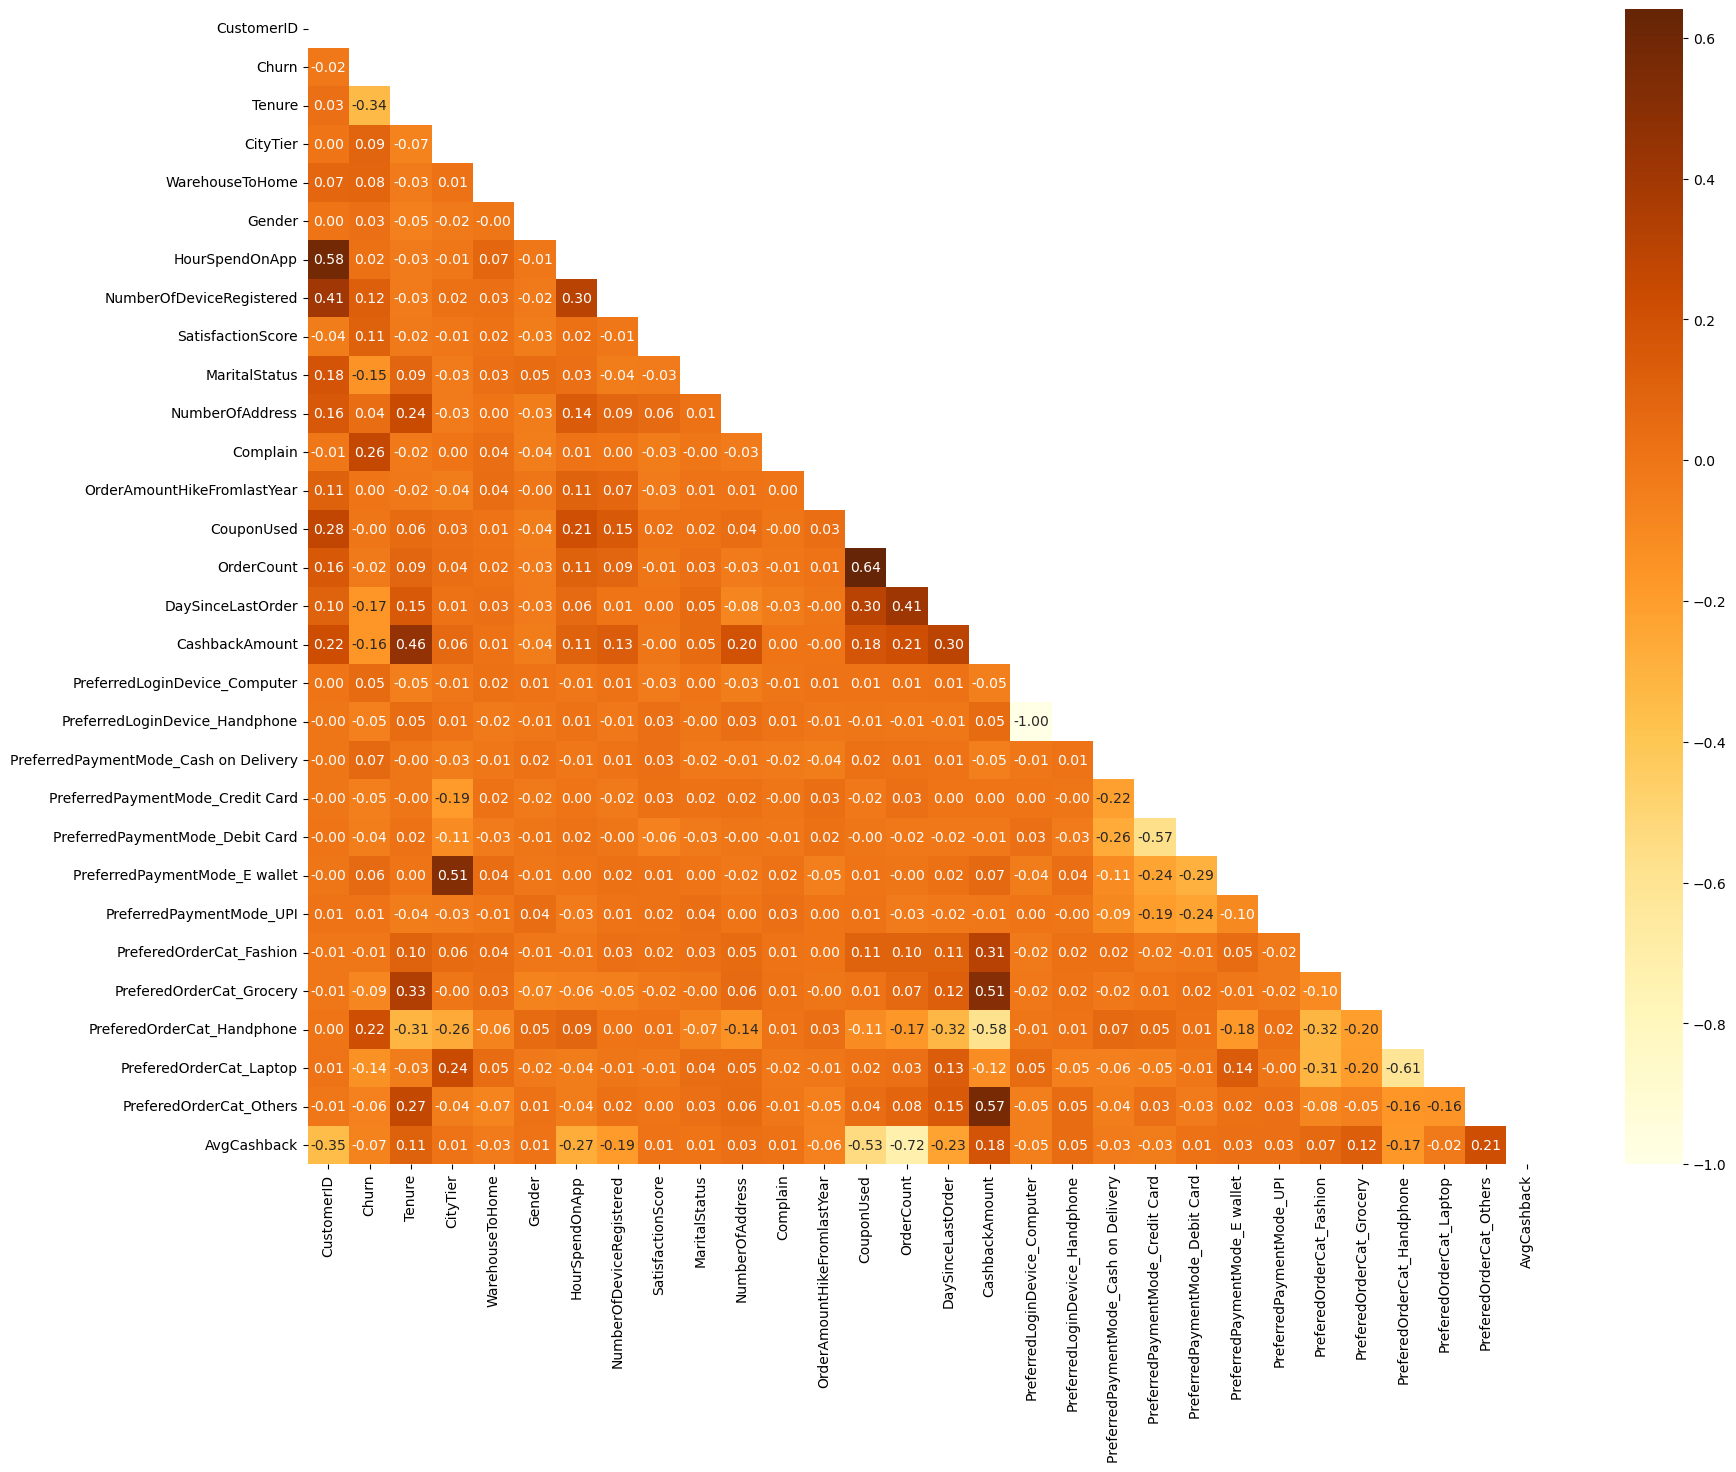

In [28]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlOrBr')

In [29]:
column = []
for col in df.columns:
    if (abs(df['Churn'].corr(df[col])) > 0.05):
        column.append(col)
df_final = df[column]
df_final.sample(3)

,Churn,Tenure,CityTier,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,Complain,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_E wallet,PreferedOrderCat_Grocery,PreferedOrderCat_Handphone,PreferedOrderCat_Laptop,PreferedOrderCat_Others,AvgCashback
2661,0,0.757643,1.474493,-0.935037,-0.658056,-1.491615,1,0,0.846479,-0.383225,1,0,0,0,0,0,1,0,-1.469894
1001,0,1.613614,1.474493,-1.307003,-0.658056,-0.040944,1,1,-1.294154,2.551922,0,1,0,1,0,0,0,1,3.747524
1676,0,-1.198863,1.474493,-1.183014,-0.658056,0.684391,1,1,-0.070935,-0.238359,1,0,0,1,0,0,1,0,1.247405


## Train Test Split Data

In [30]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Handle Class Imbalance

In [32]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(4280, 18)
(4280,)
0    3526
1     754
Name: Churn, dtype: int64


In [33]:
X_train, y_train = over_sampling.SMOTE(random_state=10).fit_resample(X_train, y_train)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(7052, 18)
(7052,)
0    3526
1    3526
Name: Churn, dtype: int64


# 3. Modeling

In [35]:
f2_score = make_scorer(fbeta_score, pos_label=0, beta=2)

In [36]:
def evaluation(model_str, y_pred, y_pred_train):
    results = {
        'model': model_str,
        'acc test' : accuracy_score(y_test, y_pred),
        'acc train': accuracy_score(y_train, y_pred_train),
        'prec test' : precision_score(y_test, y_pred),
        'prec train' : precision_score(y_train, y_pred_train),
        'rec test' : recall_score(y_test, y_pred),
        'rec train' : recall_score(y_train, y_pred_train),
        'f2 test': fbeta_score(y_test, y_pred, pos_label=0,  beta=2),
        'f2 train': fbeta_score(y_train, y_pred_train, pos_label=0,  beta=2)
    }
    return results

In [37]:
model_dict = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Light GBM': LGBMClassifier(),
    'XGBoost': XGBClassifier()
}

In [38]:
%%time
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y_train)
    y_pred = model_dict[model].predict(X_test)
    y_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y_pred, y_pred_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval

CPU times: user 6.02 s, sys: 1.7 s, total: 7.72 s
Wall time: 6.13 s


,model,acc test,acc train,prec test,prec train,rec test,rec train,f2 test,f2 train
0,Logistic Regression,0.805607,0.810976,0.420886,0.800493,0.841772,0.828417,0.828033,0.799109
1,Decision Tree,0.938318,1.000000,0.734694,1.000000,0.911392,1.000000,0.950907,1.000000
2,KNN,0.884112,0.951787,0.565891,0.915060,0.924051,0.996029,0.896861,0.923894
3,Random Forest,0.957009,1.000000,0.825581,1.000000,0.898734,1.000000,0.970084,1.000000
4,AdaBoost,0.862617,0.850113,0.522088,0.850213,0.822785,0.849972,0.887223,0.850207
5,Gradient Boosting,0.888785,0.912365,0.587444,0.911432,0.829114,0.913500,0.912125,0.911645
6,Light GBM,0.946729,0.988372,0.788571,0.982894,0.873418,0.994044,0.963020,0.984935
7,XGBoost,0.965421,0.999716,0.849711,0.999716,0.930380,0.999716,0.974697,0.999716


## Cross Validation

In [39]:
%%time
result_list = {'Model' : [], 'f2 test cv': [], 'f2 train cv': []}
for model in model_dict:
    score = cross_validate(model_dict[model], X, y, cv=5, scoring=f2_score, return_train_score=True)
    ts = score['test_score'].mean()
    tr = score['train_score'].mean()
    result_list['Model'].append(model)
    result_list['f2 test cv'].append(ts)
    result_list['f2 train cv'].append(tr)
df_eval = pd.DataFrame(result_list)
df_eval


CPU times: user 17.1 s, sys: 6.5 s, total: 23.6 s
Wall time: 17.9 s


,Model,f2 test cv,f2 train cv
0,Logistic Regression,0.950367,0.951062
1,Decision Tree,0.986906,1.000000
2,KNN,0.966477,0.975571
3,Random Forest,0.991943,1.000000
4,AdaBoost,0.948185,0.951080
5,Gradient Boosting,0.963169,0.967283
6,Light GBM,0.983350,0.997332
7,XGBoost,0.990893,0.999944


## Hyperparameter Tuning

In [40]:
%%time
model = XGBClassifier()

params = {
    'n_estimators' : [58],
    'learning_rate' : [0.46],
    'min_child_weight': [0.21],
    'alpha': [0.06]
}

grid = GridSearchCV(estimator=model, param_grid=params, scoring=f2_score, cv=5)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_pred_train = grid.predict(X_train)

result_list = []
result = evaluation('XGBoost', y_pred, y_pred_train)
result_list.append(result)
df_eval = pd.DataFrame(result_list)

print("Best score:", grid.best_score_)
print("Best parameters:", grid.best_params_)
df_eval

Best score: 0.9705538655127519
Best parameters: {'alpha': 0.06, 'learning_rate': 0.46, 'min_child_weight': 0.21, 'n_estimators': 58}
CPU times: user 3.94 s, sys: 12.9 ms, total: 3.96 s
Wall time: 3.96 s


,model,acc test,acc train,prec test,prec train,rec test,rec train,f2 test,f2 train
0,XGBoost,0.971028,0.999149,0.87574,0.998584,0.936709,0.999716,0.979336,0.998809


test score: 0.977592 train score: 0.998922 {'gamma': 0.13, 'learning_rate': 0.48, 'n_estimators': 60} <br>
baru <br>
test score: 0.972069 train score: 0.997787 {'gamma': 0.12, 'learning_rate': 0.48, 'n_estimators': 60, 'random_state': 10}

XGBoost	0.971028	0.999149	0.87574	0.998584	0.936709	0.999716	0.979336	0.998809<br>
{'alpha': 0.06, 'learning_rate': 0.46, 'min_child_weight': 0.21, 'n_estimators': 58}

XGBoost	0.970093	0.999575	0.879518	0.999716	0.924051	0.999433	0.979789	0.99966

param value: 0.01; train: 0.9997731011401668; test: (0.9773526824978013,); diff: [0.02242042]
param value: 0.02; train: 1.0; test: (0.9782369751593758,); diff: [0.02176302]
param value: 0.03; train: 0.9997731011401668; test: (0.9777826660800704,); diff: [0.02199044]
param value: 0.04; train: 0.999546176537327; test: (0.9775676270068175,); diff: [0.02197855]
param value: 0.05; train: 0.9997731011401668; test: (0.9773526824978013,); diff: [0.02242042]
param value: 0.060000000000000005; train: 0.999546176537327; test: (0.9773526824978013,); diff: [0.02219349]
param value: 0.06999999999999999; train: 1.0; test: (0.9824368825466521,); diff: [0.01756312]
param value: 0.08; train: 0.999546176537327; test: (0.9815546772068512,); diff: [0.0179915]
param value: 0.09; train: 0.9997163925127625; test: (0.9786672531339344,); diff: [0.02104914]
param value: 0.09999999999999999; train: 0.999546176537327; test: (0.978021978021978,); diff: [0.0215242]
param value: 0.11; train: 0.999546176537327; test: 

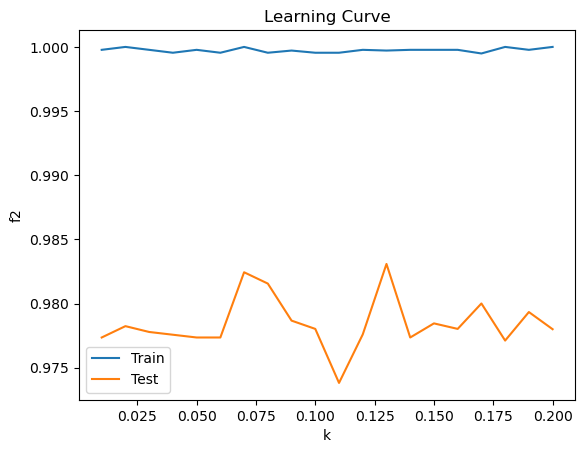

In [41]:
def draw_learning_curve(param_name, param_values):
    train_scores = []
    test_scores = []
    # dif = []

    for value in param_values:
        param = {param_name: value}
        model = XGBClassifier(**param)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train = model.predict(X_train)
        f2_train = fbeta_score(y_train, y_pred_train, pos_label=0,  beta=2)
        train_scores.append(f2_train)

        # eval on test
        y_pred = model.predict(X_test)
        f2_test = fbeta_score(y_test, y_pred, pos_label=0,  beta=2),
        test_scores.append(f2_test)
        
        diff = f2_train - f2_test
        # dif.append(diff)

        print('param value: ' + str(value) + '; train: ' + str(f2_train) + '; test: '+ str(f2_test)+ '; diff: '+ str(diff))

    fig = plt.plot(param_values, train_scores, label='Train')
    fig = plt.plot(param_values, test_scores, label='Test')
    fig = plt.xlabel('k')
    fig = plt.ylabel('f2')
    fig = plt.title('Learning Curve')
    fig = plt.legend()
    fig = plt.show()
    return fig

param_name = 'min_child_weight'
# param_values = [int(x) for x in np.linspace(1, 20,num = 20)] 
param_values = [float(x) for x in np.linspace(0.01, 0.2,num = 20)]
draw_learning_curve(param_name, param_values) #0.11,0.375

## Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

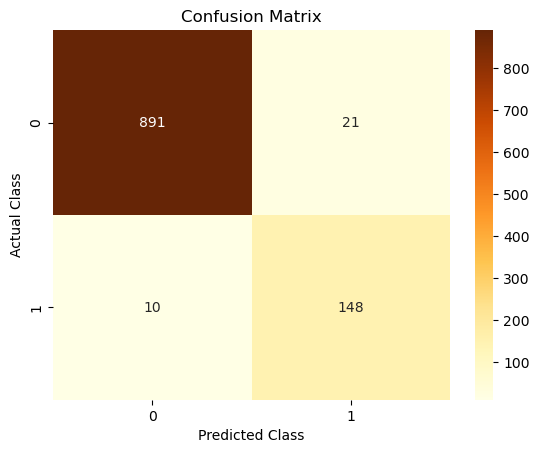

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix') # 884,28,13,145

## Feature Importance

Text(0.5, 1.0, 'feature importance score')

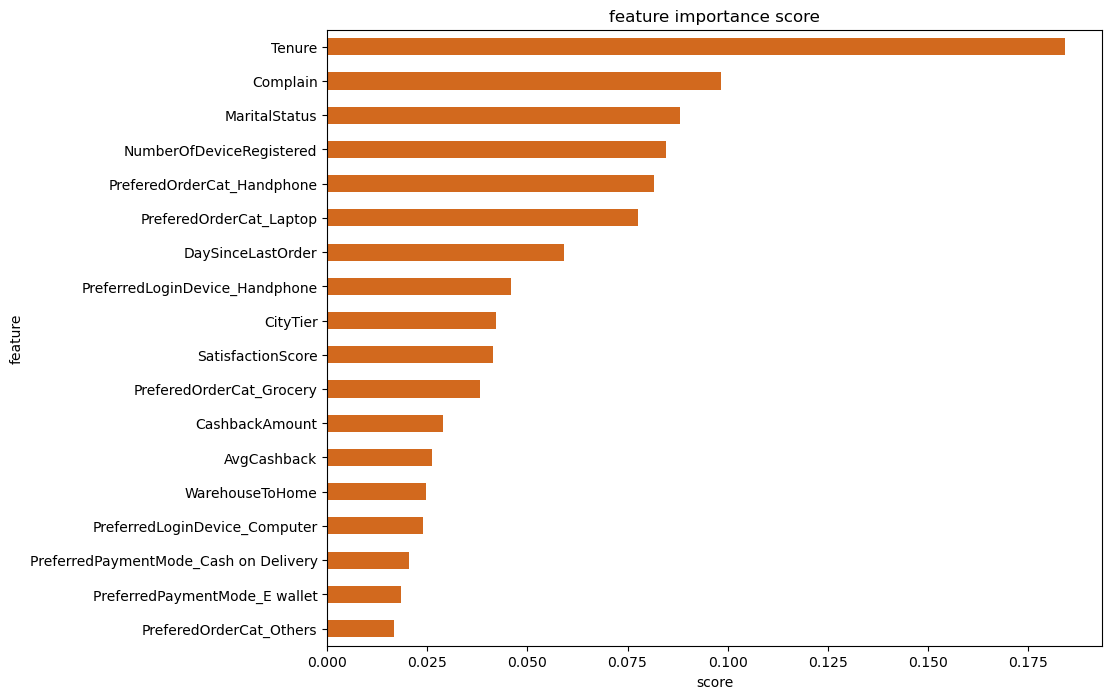

In [43]:
best_model = grid.best_estimator_
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8), color='chocolate')
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')